In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from scipy.special import softmax

from timeit import default_timer as timer
import random

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from tf_keras_vis.utils.callbacks import Print

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
#import vis.visualization
from tf_keras_vis.activation_maximization import ActivationMaximization


import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
#from sklearn.preprocessing import OrdinalEncoder
#enc = OrdinalEncoder()

#from contextlib import redirect_stdout

In [2]:
# Globals
NUM_CHANNELS = 1
RESOLUTION_LIST = [128] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["PrPo_Im"] #, "Pr_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'
FULL_MODEL_PATH = '../../results/models/opt-cnn-PrPo_Im-128-px/model'

In [3]:
m = models.load_model(FULL_MODEL_PATH)

In [ ]:
?Gradcam

In [ ]:
print(m.input)

In [ ]:
m.summary()

#### Plotting Grad-CAM

In [ ]:
def plotGradCAM(model, scenario, image_size, images_per_class = 4, trial_seed = 1, testing=True):
    image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
    
#     ALT: use train_test_split
    training_images,validation_images,training_labels,validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[image_size][scenario]]), 
                np.array([x[1] for x in image_sets[image_size][scenario]]), stratify= np.array([x[1] for x in image_sets[image_size][scenario]]), test_size=.2, random_state = trial_seed)

#     training_images_and_labels, test_images_and_labels = splitData(image_sets[image_size][scenario], prop = 0.8, seed_num = trial_seed)
#     training_images, training_labels = getImageAndLabelArrays(training_images_and_labels)
#     validation_images, validation_labels = getImageAndLabelArrays(test_images_and_labels)
    class_labels = getClassLabels(scenario)
    print("Class labels:", class_labels)
    print(training_labels.sum(axis=0)) # Sum by row
    print(validation_labels.sum(axis=0))    
    
#     ind=[5,18,86,101,180,243]
    # GRAD CAM
    random.seed(trial_seed)
    # Randomly sample images from each class
    random_image_selection_class_0 = [5, 86] #random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 0], k = images_per_class)    
#     random.seed(trial_seed+1)
    random_image_selection_class_1 = [18, 101]#random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 1], k = images_per_class)
    assert validation_labels[random_image_selection_class_0].mean(axis=0)[0] == 1 #assert that indices of class 0 labels are correct
    assert validation_labels[random_image_selection_class_1].mean(axis=0)[1] == 1 #assert that indices of class 1 labels are correct
    cam_list = random_image_selection_class_0 + random_image_selection_class_1 # join lists of indices in both classes
    if scenario=="Pr_Po_Im": # in 3-class case
        random.seed(trial_seed+2)
        random_image_selection_class_2 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 2], k = images_per_class)    
        cam_list = cam_list + random_image_selection_class_2 # join to prior list of class 0 and class 1
        assert validation_labels[random_image_selection_class_2].mean(axis=0)[2] == 1 #assert that indices of class 2 labels are correct

    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        print(output)
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in validation_labels[cam_list] ])]
        print([softmax(loss) for loss in output.numpy()])
        return loss_list

    # Model_modifier function required for gradcam
    def model_modifier(m):
        """Remove softmax activation of last layer in model"""
        m.layers[-1].activation = tf.keras.activations.linear
        return m

    # subset validation images to use for gradcam
    print("List of indices from validation images:", cam_list)
    gradcam_images = validation_images[cam_list] #tf.convert_to_tensor(validation_images[cam_list], dtype= tf.float32)
    print("Shape of gradcam image array:", gradcam_images.shape)
    print([np.argmax(j) for j in validation_labels[cam_list] ])

    # Create Gradcam object
    gradcam = Gradcam(model, model_modifier = model_modifier)#, clone=False)
    grad_cam_dir = '../../figures/plottingGradCam/'
    
    # Generate heatmap with GradCAM
    subplot_args = { 'nrows': len(class_labels), 'ncols': images_per_class, 'figsize': (3*images_per_class,3*len(class_labels)), 
                    'subplot_kw': {'xticks': [], 'yticks': []} }    
    cam = gradcam(loss, gradcam_images, penultimate_layer = -4)
    cam = normalize(cam)
    print(len(cam))
    f, ax = plt.subplots(**subplot_args)
    f.set_facecolor("white")
    image_counter = 0
    print(cam[image_counter].shape)
    for i, label in enumerate(class_labels):
        ax[i,0].set_ylabel(label, fontsize=14)
        for j in np.arange(images_per_class):
            print(i, j, image_counter)
            heatmap = np.uint8(cm.jet(cam[image_counter])[..., :3] * 255)
            ax[i, j].imshow(np.squeeze(gradcam_images[image_counter], axis=2), cmap='gist_gray') #remove axes of length one from gradcam_images
            ax[i, j].set_title(str(cam_list[image_counter]))
            #print(heatmap.shape)
            ax[i, j].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
            image_counter += 1
    plt.tight_layout()
    #plt.show()
    if not os.path.exists(grad_cam_dir):
        os.makedirs(grad_cam_dir)
    if testing==True:
        f.savefig(grad_cam_dir+"/test-opt-gradcam-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) +"-images.png")
    else:
        f.savefig(grad_cam_dir+"/opt-gradcam-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) + "-images.png")
    return

In [4]:
def plotGradCamSingleImage(image_selection_class):
    trial_seed = 1
    image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)

    #     ALT: use train_test_split
    training_images,validation_images,training_labels,validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[128]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)
    
    class_labels = getClassLabels("PrPo_Im")
    assert validation_labels[image_selection_class].mean(axis=0)[0] == 0
    cam_list = image_selection_class
    
    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        print(output)
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in validation_labels[cam_list] ])]
        print([softmax(loss) for loss in output.numpy()])
        return loss_list

    # Model_modifier function required for gradcam
    def model_modifier(m):
        """Remove softmax activation of last layer in model"""
        m.layers[-1].activation = tf.keras.activations.linear
        return m
    gradcam_images = validation_images[cam_list]
    gradcam = Gradcam(m, model_modifier = model_modifier)
    cam = gradcam(loss, gradcam_images, penultimate_layer = -4)
    cam = normalize(cam)
    
    # Generate heatmap with GradCAM
    subplot_args = { 'nrows': len(image_selection_class), 'ncols': len(image_selection_class), 'figsize': (3*len(image_selection_class),3*len(image_selection_class)), 
                    'subplot_kw': {'xticks': [], 'yticks': []} } 
    
    f, ax = plt.subplots(**subplot_args)
    f.set_facecolor("white")
    grad_cam_dir = '../../figures/plottingGradCam/'
#     image_counter = 0
#     print(cam[image_counter].shape)
#     for i, label in enumerate(class_labels):
#             plt.set_ylabel(label, fontsize=14)
#             print(i, j, image_counter)
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    plt.imshow(np.squeeze(gradcam_images[0], axis=2), cmap='gist_gray') #remove axes of length one from gradcam_images
#             plt.set_title(str(cam_list[image_counter]))
    plt.imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    plt.tight_layout()
    f.savefig(grad_cam_dir+"/single-gradcam-index" + "-" + str(image_selection_class) +"-images.png")

tf.Tensor([[-8.346948 10.684904]], shape=(1, 2), dtype=float32)
[array([5.4271445e-09, 1.0000000e+00], dtype=float32)]


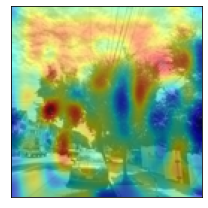

In [5]:
plotGradCamSingleImage([101])

In [7]:
def testIndex(ind, color_map='gray'):
#     ind=[5,18,86,101,180,243]
    trial_seed = 1
    grad_cam_single_dir = '../../figures/plottingGradCam/examples/'
    image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
        
    training_images,validation_images,training_labels,validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[128]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)
    print(validation_labels[[ind]])
    if color_map=='gray':
        plt.imshow(np.squeeze(validation_images[ind], axis=2), cmap='gist_gray')
    else:
        plt.imshow(np.squeeze(validation_images[ind], axis=2))
    
    if not os.path.exists(grad_cam_single_dir):
        os.makedirs(grad_cam_single_dir)
    plt.tight_layout()
#     plt.savefig(grad_cam_single_dir+'singe-'+str(ind)+'-'+str(validation_labels[ind])+'.jpg')

[[0 1]]


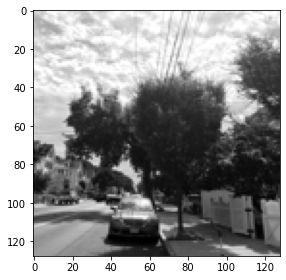

In [8]:
testIndex(101)

In [ ]:
plotGradCAM(m, "PrPo_Im", 128, images_per_class = 2, trial_seed = 1, testing=True)

## Plotting the filters
The code below generates the plot of the first filter in the first convolutional layer `conv2d`.
Expand it to plot all 64 filters in a grid

Reference: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [ ]:
# current_filter = which filter's weights we want to see
# the total filter in previous layers will be obtained from w.shape[1]
# rows * cols > total_filters
# layer_name = 'conv2d'
def plotFilters(layer_name, current_filter = 0, normalize=False):
    layer_variables = m.get_layer(layer_name).get_weights()
    filters_dir = '../../figures/plottingFilters/'+layer_name
    weights = layer_variables[0]
    biases = layer_variables[1]

    w = np.array(weights)
    print(w.shape)
    

    w = np.moveaxis(w, 2, 0) #what does this do?
    w = np.moveaxis(w, 3, 0) #what does this do?
    print(w.shape)

    if normalize: #scale all pixels from 0 - 1
        w_min, w_max = w.min(), w.max()
        w = (w - w_min) / (w_max - w_min)

    fig = plt.figure(figsize=(10, 10))
    
    if w.shape[0] == 64:
        rows, cols = 8, 8
    elif w.shape[0] == 128:
        rows, cols = 16, 8
    elif w.shape[0] == 256:
        rows, cols = 16, 16

    plot_x = -8.1
    plot_y = -0.85
    
    if w.shape[1] == 1: # first layer
        for filter in range(w.shape[0]):
            fig.add_subplot(rows, cols, filter+1)
            plt.imshow(w[filter][0], cmap='gray')
            plt.xticks([])
            plt.yticks([])
            plt.subplots_adjust(wspace=0, hspace=0)
            plot_x = -3.1
            plot_y = -0.35
    else:
        for each_depth in range(w.shape[1]):
            fig.add_subplot(rows, cols, each_depth+1)
            plt.imshow(w[current_filter][each_depth], cmap='gray')
            plt.xticks([])
            plt.yticks([])
    plt.title('Filter visualization for layer '+layer_name+', filter '+str(current_filter),x=plot_x, y=plot_y)
    if not os.path.exists(filters_dir):
        os.makedirs(filters_dir)
    plt.savefig(filters_dir+'/plot-filters-'+layer_name+'-'+str(current_filter)+".png",bbox_inches='tight')
    
    return

In [ ]:
plotFilters('conv2d',1000)

In [ ]:
CONV_LAYERS = {'conv2d':0}

def plotAllFilters():
    l = ""
    f = 0
    for layer in CONV_LAYERS:
        l = layer
        for i in range(CONV_LAYERS[layer]):
            f = f + i 
            plotFilters(layer, i)
    print("Plotting completed for layer " + l + ". Total filters plotted: " + str(f))

In [ ]:
plotAllFilters()

In [ ]:
def plotActivations(resolution, scenario, layer_name, image_index, cols, rows):
    """Always put docstrings for functions..."""
    image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
    ### train/test split can be done outside function
    X_train, X_test, y_train, y_test =  train_test_split(
        np.array([np.expand_dims(x[0],axis=2) for x in image_sets[resolution][scenario]]), 
        np.array([x[1] for x in image_sets[resolution][scenario]]), 
        stratify= np.array([x[1] for x in image_sets[resolution][scenario]]), #Same distribution of the clases
        test_size = .2, 
        random_state = 1)

    
    intermediate_layer_model = models.Model(inputs=m.inputs, outputs=m.get_layer(layer_name).output)
    image = np.expand_dims(X_test[image_index], axis = 0) ## can be argument to function
    print("Input image shape:", image.shape)
    feature_maps = intermediate_layer_model.predict(image)

    print("Feature maps shape:", feature_maps.shape)



    output = np.squeeze(feature_maps)
    output = np.moveaxis(output, 2, 0)

    print(output.shape)


	
    # plot all 64 maps in an 8x8 squares
    if output.shape[2] == 64:
        rows, cols = 8, 8
    elif output.shape[2] == 128:
        rows, cols = 16, 8
    elif output.shape[2] == 256:
        rows, cols = 16, 16
        
    fig = plt.figure(figsize=(10, 10))
    plot_x = -3.1
    plot_y = -0.45
    
    ix = 1
    for i in range(rows):
        for j in range(cols):
            # specify subplot and turn of axis
            ax = plt.subplot(rows, cols, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            plt.subplots_adjust(wspace=0, hspace=0)   
            ix += 1
        

    activations_dir = '../../figures/plottingActivations/'+layer_name+'/'
    plt.title('Feature map activations for layer '+layer_name+', index '+str(image_index)+', input class '+str(np.argmax(y_test[image_index])),x=plot_x, y=plot_y) #plt.title("Label: " + str(np.argmax(y_test[image_index])))
    if not os.path.exists(activations_dir):
        os.makedirs(activations_dir)
    plt.savefig(activations_dir+layer_name+'-'+scenario+'-'+str(image_index)+'-'+str(cols)+'-'+str(rows)+".png",bbox_inches='tight')
#     for i in range(output.shape[0]):
#         fig.add_subplot(rows, cols, i+1)
#         plt.imshow(output[i], cmap='gray')
#         plt.subplots_adjust(wspace=0, hspace=0)   
    return #good practice to always include return statements

In [ ]:
ind = [5,18,86,101,180,243]
layers = ['conv2d', 'conv2d_4']
for l in layers:
    for i in ind:
        plotActivations(128, 'PrPo_Im', l, i, 16, 16)

In [ ]:
def plotAllActivations(indices):
    CONV_LAYERS = ['conv2d', 'conv2d_4']
    for layer in CONV_LAYERS:
        for i in indices:
            plotActivations(128, 'PrPo_Im', layer, i, 8, 8)

In [ ]:
ind=[5,18,86,101,180,243]
plotAllActivations(ind)

To plot feature map activations, the `keract` library might be a good alternative: https://github.com/philipperemy/keract#display-the-activations-as-a-heatmap-overlaid-on-an-image

The example below still needs debugging but was adapted from: https://github.com/meet-minimalist/Visualize-CNN-Filters/blob/master/Visualize%20CNN%20Layer%20Outputs%20and%20Filters.ipynb

### First, write a function to generate the activation maximization image, then call it in a loop for the subplot

In [ ]:
def generateActivationMaximization(filter_number, layer_name):
    def model_modifier(current_model):
        target_layer = current_model.get_layer(name=layer_name)
        new_model = tf.keras.Model(inputs=current_model.inputs,
                                   outputs=target_layer.output)
        new_model.layers[-1].activation = tf.keras.activations.linear
        return new_model
    
    
    activation_maximization = ActivationMaximization(m,
                                                     model_modifier,
                                                     )
    
    def loss(output):
        return output[..., filter_number]
    
    # Generate activations and convert into images
    activation = activation_maximization(loss) #, steps=512, input_range=(30,150)
    

    # Generate max activation
#     activation = activation_maximization(loss,seed)
    print(activation[0].shape)
    image = activation[0].astype(np.uint8)
    # Render
#     activation_max_dir = '../../figures/plottingActivationMaximizations/'+layer_name+'/'
#     subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (3, 3),
#                      'subplot_kw': {'xticks': [], 'yticks': []} }
#     f, ax = plt.subplots(**subplot_args)
#     ax.imshow(np.squeeze(image, axis=2)) #squeeze dimensions
#     ax.set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
    
#     plt.tight_layout()
#     plt.suptitle(layer_name,y=-0.0001)
#     if not os.path.exists(activation_max_dir):
#         os.makedirs(activation_max_dir)
#     plt.savefig(activation_max_dir+layer_name+'-'+str(filter_number)+".png",bbox_inches='tight')
#     plt.show()
    return image

In [ ]:
### NEW
def plotActivationMaximizationMultiple(layer_name, rows, cols): 
#     seed = 101
    # Generate a random seed for each activation
#     seed_input = tf.random.uniform((128, 128, 1), 0, 255)
    ix = 1
    activation_max_dir = '../../figures/plottingActivationMaximizations/'+layer_name+'/'
    fig = plt.figure(figsize=(10, 10))
    for i in range(rows):
        for j in range(cols):
            # specify subplot and turn of axis
            ax = plt.subplot(rows, cols, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(np.squeeze(generateActivationMaximization(ix-1, layer_name)))#, cmap='gray')
            plt.subplots_adjust(wspace=0, hspace=0)   
            ix += 1
    if not os.path.exists(activation_max_dir):
        os.makedirs(activation_max_dir)
    plt.savefig(activation_max_dir+layer_name+".png",bbox_inches='tight')
    return

In [ ]:
def plotActivationMaximizationMultipleLayers():
    CONV_LAYERS = {'conv2d':64,
                   'conv2d_4':256}
    for layer in CONV_LAYERS:
        plotActivationMaximizationMultiple(layer, 8, 8)

#### Generate all activations maximizations for a given layer

In [ ]:
start = timer()
plotActivationMaximizationMultiple('conv2d_4', 16, 16)
end = timer()
print(end - start)

In [281]:
def plotSaliency(model, scenario, image_size, images_per_class = 4, trial_seed = 21, saliency=False, testing=True):
    training_images_and_labels, test_images_and_labels = splitData(image_sets[image_size][scenario], prop = 0.8, seed_num = trial_seed)
    training_images, training_labels = getImageAndLabelArrays(training_images_and_labels)
    validation_images, validation_labels = getImageAndLabelArrays(test_images_and_labels)
    saliency_dir = '../../figures/plottingSaliency/'
    class_labels = getClassLabels(scenario)
    print("Class labels:", class_labels)
    print(training_labels.sum(axis=0))
    print(validation_labels.sum(axis=0))    
    
    # GRAD CAM
    random.seed(trial_seed)
    # Randomly sample images from each class
    random_image_selection_class_0 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 0], k = images_per_class)    
    random.seed(trial_seed+1)
    random_image_selection_class_1 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 1], k = images_per_class)
    assert validation_labels[random_image_selection_class_0].mean(axis=0)[0] == 1 #assert that indices of class 0 labels are correct
    assert validation_labels[random_image_selection_class_1].mean(axis=0)[1] == 1 #assert that indices of class 1 labels are correct
    cam_list = random_image_selection_class_0 + random_image_selection_class_1 # join lists of indices in both classes
    if scenario=="Pr_Po_Im": # in 3-class case
        random.seed(trial_seed+2)
        random_image_selection_class_2 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 2], k = images_per_class)    
        cam_list = cam_list + random_image_selection_class_2 # join to prior list of class 0 and class 1
        assert validation_labels[random_image_selection_class_2].mean(axis=0)[2] == 1 #assert that indices of class 2 labels are correct
    # subset validation images to use for gradcam
    print("List of indices from validation images:", cam_list)
    gradcam_images = validation_images[cam_list] #tf.convert_to_tensor(validation_images[cam_list], dtype= tf.float32)
    print("Shape of gradcam image array:", gradcam_images.shape)
    print([np.argmax(j) for j in validation_labels[cam_list] ])

    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        print(output)
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in validation_labels[cam_list] ])]
        print([softmax(loss) for loss in output.numpy()])
        return loss_list
    
    # Model_modifier function required for gradcam
    def model_modifier(m):
        """Remove softmax activation of last layer in model"""
        m.layers[-1].activation = tf.keras.activations.linear
        return m
    
    subplot_args = { 'nrows': len(class_labels), 'ncols': images_per_class, 'figsize': (3*images_per_class,3*len(class_labels)), 
                    'subplot_kw': {'xticks': [], 'yticks': []} }    

    saliency = Saliency(model, model_modifier=model_modifier)#                    clone=False)

    # Generate saliency map with smoothing that reduce noise by adding noise
    saliency_map = saliency(loss, gradcam_images, 
                            smooth_samples=20, # The number of calculating gradients iterations.
                            smooth_noise=0.20) # noise spread level.
    saliency_map = normalize(saliency_map)
    #image_titles = class_labels
    f, ax = plt.subplots(**subplot_args)
    f.set_facecolor("white")
    image_counter = 0
    for i, label in enumerate(class_labels):
        ax[i,0].set_ylabel(label, fontsize=14)
        for j in np.arange(images_per_class):
            print(i, j, image_counter)
            ax[i, j].imshow(saliency_map[image_counter], cmap='jet', alpha=0.5) # overlay
            image_counter += 1
    plt.tight_layout()
    #plt.show()
    if not os.path.exists(saliency_dir):
        os.makedirs(saliency_dir)
    if testing == True:
        f.savefig(saliency_dir+"test-opt-saliency-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) + "-images.png")
    else:
        f.savefig(saliency_dir+"opt-saliency-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) + "-images.png")
    return



Class labels: ['Probable/Possible', 'Improbable']
[   1 1831]
[  3 455]
List of indices from validation images: [62, 96, 72, 126]
Shape of gradcam image array: (4, 128, 128, 1)
[0, 0, 1, 1]
tf.Tensor(
[[ 1.9425194 -3.47327  ]
 [ 1.5310881 -2.5828161]
 [-1.9196229  1.643872 ]
 [-2.4556422  4.9484587]], shape=(4, 2), dtype=float32)
[array([0.99557394, 0.00442615], dtype=float32), array([0.98391896, 0.01608101], dtype=float32), array([0.02755861, 0.9724413 ], dtype=float32), array([6.0838094e-04, 9.9939173e-01], dtype=float32)]
tf.Tensor(
[[ 3.3595073 -4.587723 ]
 [ 1.1635947 -2.4026175]
 [-1.8263249  1.8577113]
 [-2.1066136  5.0710335]], shape=(4, 2), dtype=float32)
[array([9.9964648e-01, 3.5351535e-04], dtype=float32), array([0.97251415, 0.02748588], dtype=float32), array([0.02450575, 0.9754942 ], dtype=float32), array([7.6287979e-04, 9.9923736e-01], dtype=float32)]
tf.Tensor(
[[ 2.4009166 -3.8203654]
 [ 1.2356517 -2.2199504]
 [-1.8999736  1.3806986]
 [-1.778463   4.62067  ]], shape=(4,

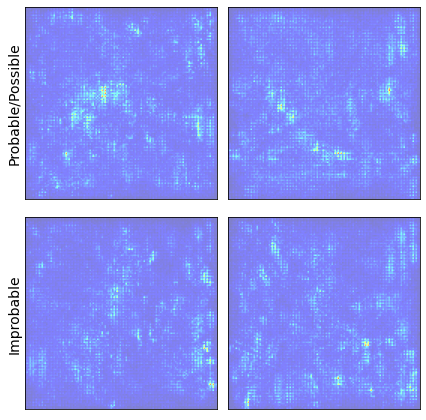

In [282]:
plotSaliency(m, "PrPo_Im", 128, images_per_class = 2, trial_seed = 21,  saliency=True, testing=True)

In [ ]:
from vis.visualization import get_num_filters

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'block1_conv2'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()